In [3]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,404 k

In [1]:
import cv2
import numpy as np


class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels



def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

# Reconstruction function from predict value into plate crpoped from image
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (470, 110)
    two_lines = (280, 200)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size 
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))
        
    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    #print(final_labels_frontal)
    assert final_labels_frontal, "No License plate is founded!"

    # LP size and type
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.7) else (one_line, 1)

    TLp = []
    Cor = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)
            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
            Cor.append(ptsh)
    return final_labels, TLp, lp_type, Cor

def detect_lp(model, I, max_dim, lp_threshold):
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor).astype(int).tolist()
    Iresized = cv2.resize(I, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    Yr = model.predict(T)
    Yr = np.squeeze(Yr)
    #print(Yr.shape)
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, Yr, lp_threshold)
    return L, TLp, lp_type, Cor

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os.path import splitext,basename
from keras.models import model_from_json
import glob
import pytesseract
from PIL import Image

In [5]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [ ]:
! git clone https://github.com/quangnhat185/Plate_detect_and_recognize.git

In [ ]:
wpod_net_path = "/content/Plate_detect_and_recognize/wpod-net.json"
wpod_net = load_model(wpod_net_path)

In [8]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

In [9]:
def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    print(vehicle.shape[:2])
    side = int(ratio * Dmin)
    print('side: ',side)
    bound_dim = min(side, Dmax)
    print('boundary: ',bound_dim)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.7)
    return LpImg, cor

(225, 400)
side:  455
boundary:  455


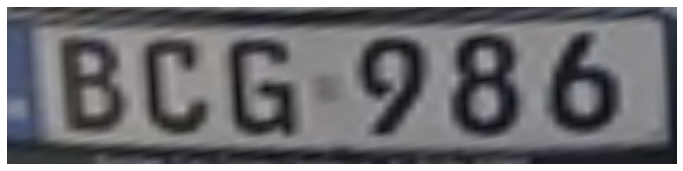

In [21]:
test_image = '/content/Cars430.png'
LpImg,cor = get_plate(test_image)
#this is to  Visualize our result
plt.figure(figsize=(12,5))
plt.axis(False)
plt.imshow(LpImg[0])


In [ ]:
l=[]
# batch 1
x=91
y=121

for i in range(x,y):
    img = '/content/{}.jpg'.format(i)
    #print(i,sep=' ',end='')
    print(i)
    if i in [11,16,17,26,28,30,32,34,35,36,38,40,41,67,83,93,107,90,95,110,112,117,118,120]:
      continue
    LpImg,cor = get_plate(img)
    im = Image.fromarray((LpImg[0]* 255).astype(np.uint8))
    text = pytesseract.image_to_string(im)
    l.append(['{}'.format(i),text])

In [ ]:
im = Image.fromarray((LpImg[0]* 255).astype(np.uint8))
text = pytesseract.image_to_string(im)
text

'BES |\n\x0c'

### text prediction for batch 1

In [ ]:
import pytesseract
from PIL import Image
test_image = '/content/2.jpg'
LpImg,cor = get_plate(test_image)
im = Image.fromarray((LpImg[0]* 255).astype(np.uint8))
text = pytesseract.image_to_string(im)

In [ ]:
l

[['1', '\x0c'],
 ['2', '20EJ0365|\n\x0c'],
 ['3', '| MH20 DV 2363|\n\x0c'],
 ['4', '‘MH 20EE 7598}\n\x0c'],
 ['5', '\x0c'],
 ['6', 'MH12DE 14331\n\x0c'],
 ['7', '0 ye\n\x0c'],
 ['8', '| TN 23 AL 0322\n\x0c'],
 ['9', '| MH.04.EX.4491)\n\x0c'],
 ['10', 'MH.O4.EF.3049°\n\x0c'],
 ['12', ' \n\x0c'],
 ['13', 'MH L43N 7848)\n\x0c'],
 ['14', 'RIVLUK 7 11\n\x0c'],
 ['15', '23 SH Vest\n\n \n\x0c'],
 ['18', 'THOIATC686\n\x0c'],
 ['19', 'TN &3 82 9797\n\x0c'],
 ['20', 'HR5 1AS3690.\n\x0c'],
 ['21', 't i a? ‘ia\n\x0c'],
 ['22', '| KL 58.6 100\n\x0c'],
 ['23', '| KA 28 Z 1445 |\n\x0c'],
 ['24', 'sMH4G6AP3771\n\neee\n\x0c'],
 ['25', 'iN 2e @ 7150\n\x0c'],
 ['27', 'MH 01 CP 6892\n\x0c'],
 ['29', '\x0c']]

### text prediction for batch 2

In [ ]:
l

[['31', 'MM D867\n\x0c'],
 ['33', 'JTN19 B 8193\n\x0c'],
 ['37', 'MHLOLBU.DOLE\n\x0c'],
 ['39', 'hans: 3 V 20 23\n\x0c'],
 ['42', '\x0c'],
 ['43', 'KA 64 N G699\n\x0c'],
 ['44', 'SDLECAYS 28)\n\x0c'],
 ['45', 'TN 38 BR 3036,\n\x0c'],
 ['46', 'a _—_—\n5 t 7758\n\x0c'],
 ['47', '_ 7 SHAR I\n\x0c'],
 ['48', 'Li es, lands-CC(H onorary)\n\nKA 02 MH 97\n\n     \n\x0c'],
 ['49', ' \n\x0c'],
 ['50', ' \n\x0c'],
 ['51', '—TSO8 EM 6424\n\x0c'],
 ['52', 'KA G5 NG 1909\n\x0c'],
 ['53', 'aL rag\n\x0c'],
 ['54', 'KL 9 AK 7227\n\x0c'],
 ['55', '| TN 23 AL 0322\n\x0c'],
 ['56', 'MH.12 FK.7368.\n\x0c'],
 ['57', 'MH.20.0H.3696\n\x0c'],
 ['58', 'IR26DG6 167.\n\x0c'],
 ['59', 'KL 25 K 9432\n\n \n\x0c'],
 ['60', '| MH 27 BX 0938\n\x0c']]

### test prediction for batch 3

In [ ]:
l

[['61', 'MH. 20 BC.2944\n\x0c'],
 ['62', 'CC 50\n\x0c'],
 ['63', 'KL elo 4343 |\n\x0c'],
 ['64', 'KL7_ CQ 7070\n\x0c'],
 ['65', ': KLO1AT5555|\n\x0c'],
 ['66', '\x0c'],
 ['68', 'MH 02 BJ 700\n\x0c'],
 ['69', ' \n\x0c'],
 ['70', 'iMH14DN 10401\n\x0c'],
 ['71', 'RITLCP 1\n\x0c'],
 ['72', '\x0c'],
 ['73', ' \n\x0c'],
 ['74', ' \n\x0c'],
 ['75', 'HRS 1893737]\n\x0c'],
 ['76', 'DL3C AQ5863\n\x0c'],
 ['77', 'DL2FFYOOOI\n\x0c'],
 ['78', 'DLIOCS 7426\n\x0c'],
 ['79', 'E\n\x0c'],
 ['80', '\x0c'],
 ['81', ' \n\nmD4 CC Z646;\n\n \n\x0c'],
 ['82', '7 M 3773.\n\x0c'],
 ['84', '\x0c'],
 ['85', 'Pst tS\n\x0c'],
 ['86', '-DE1433|\n\x0c'],
 ['87', '\x0c'],
 ['88', 'ee\nMH13 BN 8454\n\x0c'],
 ['89', ' \n\x0c']]

### test perdiction for batch 4

In [ ]:
l

[['91', 'EE\nKA-04 MP 3867\n\x0c'],
 ['92', '"\n\nKA01 TC 365°\n\x0c'],
 ['94', 'TNO2AK8055 |\n\x0c'],
 ['96', 'KL 40 L 5577\n\x0c'],
 ['97', ' \n\x0c'],
 ['98', '\x0c'],
 ['99', 'UAO7 H 6032\n\x0c'],
 ['100', ' \n\x0c'],
 ['101', 'PBO2 BB 8343\n\x0c'],
 ['102', 'TN*64 D 4256\n\x0c'],
 ['103', '\x0c'],
 ['104', '“DL3C AM 0857)\n\x0c'],
 ['105', ' \n\x0c'],
 ['106', 'HR 99 VW (rewe) 8776\n\x0c'],
 ['108', 'ia is MF 9960\n\x0c'],
 ['109', '\x0c'],
 ['111', 'pk :4c00004]\n\x0c'],
 ['113', 'Greer\n\x0c'],
 ['114', 'MH 14GA 5284)\n\x0c'],
 ['115', '03-MG- 2784.\n\x0c'],
 ['116', '\x0c'],
 ['119', 'oe\nAR 26 AL DTTL\n\x0c']]

### Batch-1

Found 30 images...
/content/9.jpg
(375, 500)
side:  341
boundary:  341
/content/23.jpg
(595, 1024)
side:  440
boundary:  440
/content/15.jpg
(302, 500)
side:  423
boundary:  423
/content/7.jpg
(178, 284)
side:  408
boundary:  408
/content/11.jpg
(187, 269)
side:  368
boundary:  368
/content/8.jpg
(186, 270)
side:  371
boundary:  371
/content/24.jpg
(287, 459)
side:  409
boundary:  409
/content/25.jpg
(264, 468)
side:  453
boundary:  453
/content/3.jpg
(548, 960)
side:  448
boundary:  448
/content/27.jpg
(578, 872)
side:  386
boundary:  386
/content/14.jpg
(224, 224)
side:  256
boundary:  256
/content/4.jpg
(338, 600)
side:  454
boundary:  454
/content/22.jpg
(202, 250)
side:  316
boundary:  316
/content/2.jpg
(338, 600)
side:  454
boundary:  454
/content/12.jpg
(1920, 1440)
side:  341
boundary:  341
/content/20.jpg
(600, 1200)
side:  512
boundary:  512
/content/19.jpg
(752, 961)
side:  327
boundary:  327
/content/1.jpg
(500, 1400)
side:  716
boundary:  608
/content/6.jpg
(768, 1024)
si

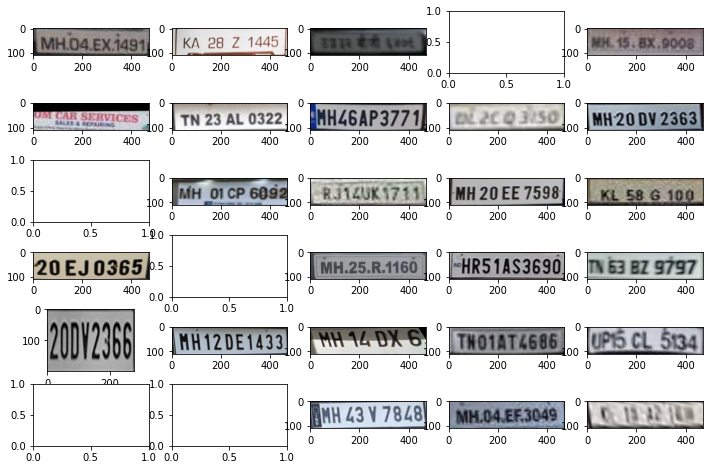

In [ ]:
image_paths = glob.glob("/content/*.jpg")
print("Found %i images..."%(len(image_paths)))
# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 6
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))    
    img=image_paths[i]
    if img=='/content/16.jpg' or img=='/content/28.jpg'or img=='/content/26.jpg'or img=='/content/30.jpg'or img=='/content/17.jpg':
       continue
    print(img)
    LpImg,cor = get_plate(img)
    plt.imshow(LpImg[0])


plt.show()

1
(500, 1400)
side:  716
boundary:  608
2
(338, 600)
side:  454
boundary:  454
3
(548, 960)
side:  448
boundary:  448
4
(338, 600)
side:  454
boundary:  454
5
(1440, 1920)
side:  341
boundary:  341
6
(768, 1024)
side:  341
boundary:  341
7
(178, 284)
side:  408
boundary:  408
8
(186, 270)
side:  371
boundary:  371
9
(375, 500)
side:  341
boundary:  341
10
(194, 260)
side:  343
boundary:  343
11
(187, 269)
side:  368
boundary:  368
12
(1920, 1440)
side:  341
boundary:  341
13
(2000, 1210)
side:  423
boundary:  423
14
(224, 224)
side:  256
boundary:  256
15
(302, 500)
side:  423
boundary:  423
16
17
18
(175, 250)
side:  365
boundary:  365
19
(752, 961)
side:  327
boundary:  327
20
(600, 1200)
side:  512
boundary:  512
21
(192, 262)
side:  349
boundary:  349
22
(202, 250)
side:  316
boundary:  316
23
(595, 1024)
side:  440
boundary:  440
24
(287, 459)
side:  409
boundary:  409
25
(264, 468)
side:  453
boundary:  453
26
27
(578, 872)
side:  386
boundary:  386
28
29
(286, 500)
side:  447
bo

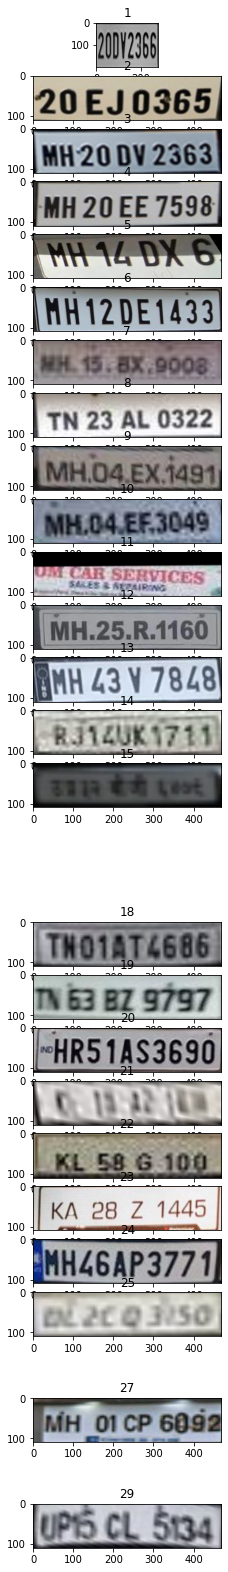

In [ ]:
# batch 1
x=1
y=31
fig = plt.figure(figsize=(30,30))
fig_list = []

for i in range(x,y):
    img = '/content/{}.jpg'.format(i)
    #print(i,sep=' ',end='')
    print(i)
    if i in [16,17,26,28,30]:
      continue
    fig_list.append(fig.add_subplot(y,x,i))
    fig_list[-1].set_title(i)
    p,c=get_plate(img)
    plt.imshow(p[0])

### Images that were not detected


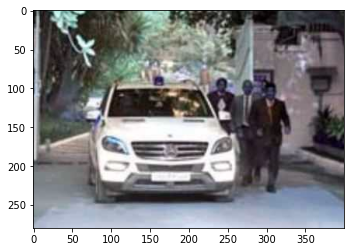

In [ ]:
test_image =cv2.imread('/content/16.jpg')
plt.imshow(test_image)

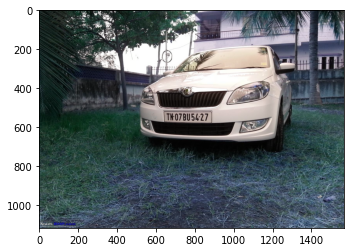

In [ ]:
test_image =cv2.imread('/content/17.jpg')
plt.imshow(test_image)

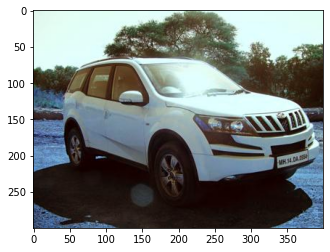

In [ ]:
test_image =cv2.imread('/content/26.jpg')
plt.imshow(test_image)

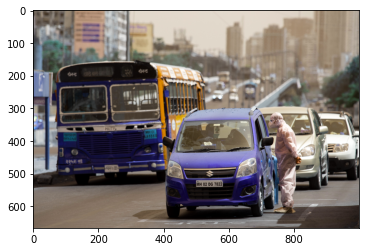

In [ ]:
test_image =cv2.imread('/content/28.jpg')
plt.imshow(test_image)

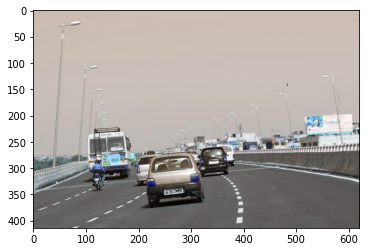

In [ ]:
test_image =cv2.imread('/content/30.jpg')
plt.imshow(test_image)

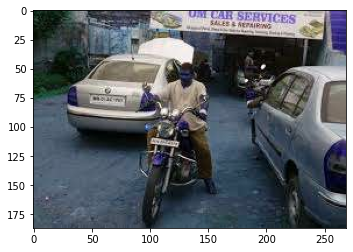

In [ ]:
test_image =cv2.imread('/content/11.jpg')
plt.imshow(test_image)

Batch -2

31
(380, 590)
side:  397
boundary:  397
32
33
(490, 590)
side:  308
boundary:  308
34
35
36
37
(650, 550)
side:  302
boundary:  302
38
39
(540, 960)
side:  455
boundary:  455
40
41
42
(449, 660)
side:  376
boundary:  376
43
(225, 225)
side:  256
boundary:  256
44
(176, 286)
side:  416
boundary:  416
45
(224, 225)
side:  257
boundary:  257
46
(255, 400)
side:  401
boundary:  401
47
(300, 168)
side:  457
boundary:  457
48
(1024, 765)
side:  342
boundary:  342
49
(376, 620)
side:  422
boundary:  422
50
(1077, 1616)
side:  384
boundary:  384
51
(165, 305)
side:  473
boundary:  473
52
(194, 259)
side:  341
boundary:  341
53
(194, 259)
side:  341
boundary:  341
54
(848, 1272)
side:  384
boundary:  384
55
(186, 270)
side:  371
boundary:  371
56
(194, 259)
side:  341
boundary:  341
57
(194, 259)
side:  341
boundary:  341
58
(162, 311)
side:  491
boundary:  491
59
(194, 259)
side:  341
boundary:  341
60
(2000, 1500)
side:  341
boundary:  341


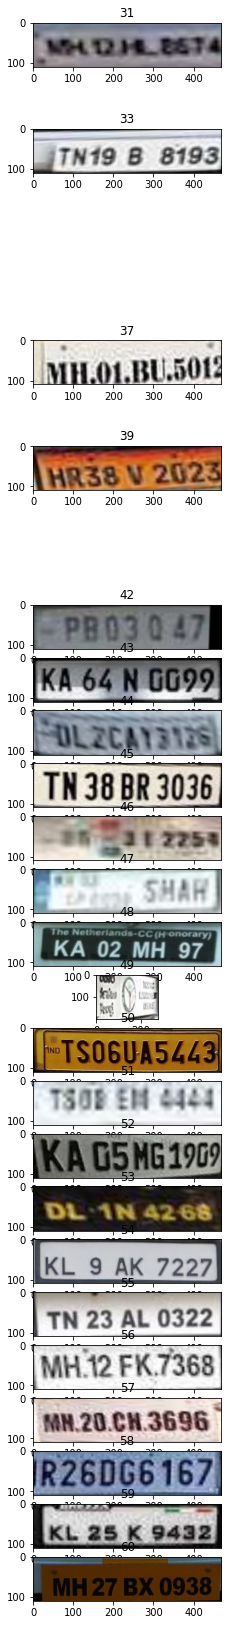

In [ ]:
x=31
y=61
fig = plt.figure(figsize=(30,30))
fig_list = []

for i in range(x,y):
    img = '/content/{}.jpg'.format(i)
    #print(i,sep=' ',end='')
    print(i)
    if i in [32,34,35,36,38,40,41]:
      continue
    fig_list.append(fig.add_subplot(y-30,x-30,i-30))
    fig_list[-1].set_title(i)
    p,c=get_plate(img)
    plt.imshow(p[0])

### images not predcted in batch-2

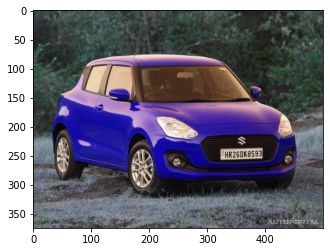

In [ ]:
test_image =cv2.imread('/content/32.jpg')
plt.imshow(test_image)

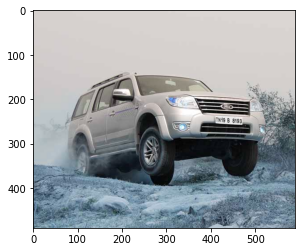

In [ ]:
test_image =cv2.imread('/content/33.jpg')
plt.imshow(test_image)

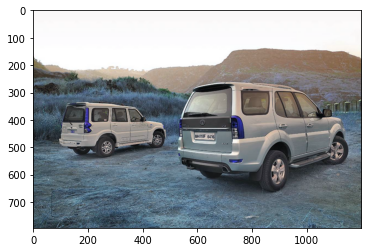

In [ ]:
test_image =cv2.imread('/content/34.jpg')
plt.imshow(test_image)

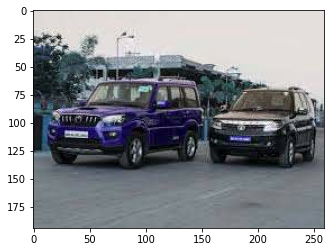

In [ ]:
test_image =cv2.imread('/content/35.jpg')
plt.imshow(test_image)

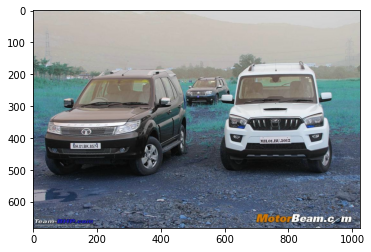

In [ ]:
test_image =cv2.imread('/content/36.jpg')
plt.imshow(test_image)

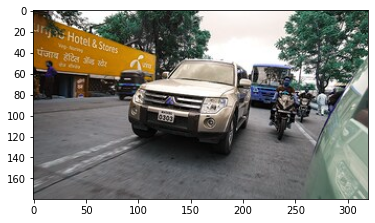

In [ ]:
test_image =cv2.imread('/content/38.jpg')
plt.imshow(test_image)

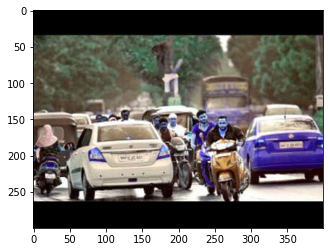

In [ ]:
test_image =cv2.imread('/content/40.jpg')
plt.imshow(test_image)

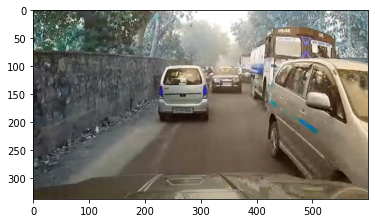

In [ ]:
test_image =cv2.imread('/content/41.jpg')
plt.imshow(test_image)

### Batch -3

61
(750, 1000)
side:  341
boundary:  341
62
(153, 328)
side:  548
boundary:  548
63
(720, 960)
side:  341
boundary:  341
64
(561, 750)
side:  342
boundary:  342
65
(448, 800)
side:  457
boundary:  457
66
(178, 284)
side:  408
boundary:  408
67
68
(236, 236)
side:  256
boundary:  256
69
(544, 715)
side:  336
boundary:  336
70
(499, 600)
side:  307
boundary:  307
71
(555, 740)
side:  341
boundary:  341
72
(200, 300)
side:  384
boundary:  384
73
(156, 322)
side:  528
boundary:  528
74
(194, 259)
side:  341
boundary:  341
75
(300, 400)
side:  341
boundary:  341
76
(1200, 900)
side:  341
boundary:  341
77
(423, 634)
side:  383
boundary:  383
78
(749, 1200)
side:  410
boundary:  410
79
(318, 610)
side:  491
boundary:  491
80
(168, 300)
side:  457
boundary:  457
81
(480, 640)
side:  341
boundary:  341
82
(189, 267)
side:  361
boundary:  361
83
84
(225, 225)
side:  256
boundary:  256
85
(400, 600)
side:  384
boundary:  384
86
(194, 259)
side:  341
boundary:  341
87
(416, 456)
side:  280
bounda

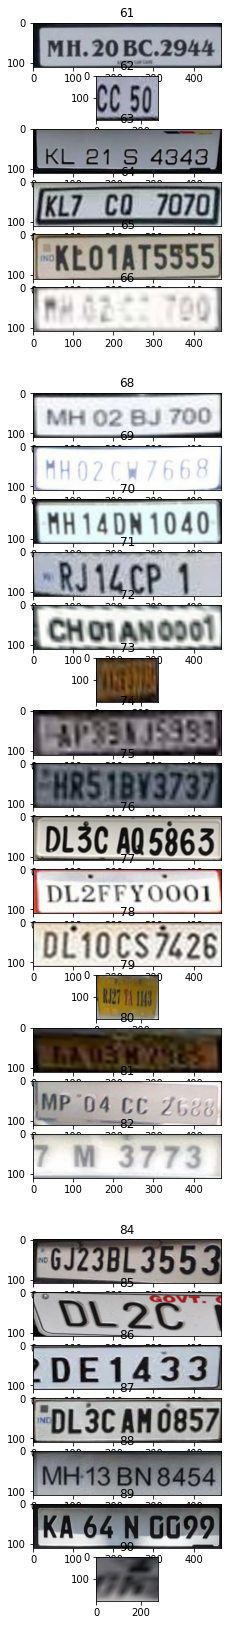

In [ ]:
# batch 1
x=61
y=91
fig = plt.figure(figsize=(30,30))
fig_list = []

for i in range(x,y):
    img = '/content/{}.jpg'.format(i)
    #print(i,sep=' ',end='')
    print(i)
    if i in [67,83]:
      continue
    fig_list.append(fig.add_subplot(y-60,x-60,i-60))
    fig_list[-1].set_title(i)
    p,c=get_plate(img)
    plt.imshow(p[0])

### images not predicted in batch -3 

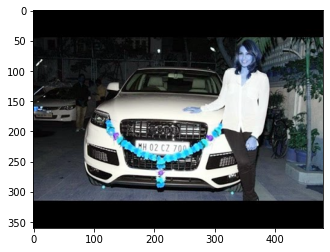

In [ ]:
test_image =cv2.imread('/content/67.jpg')
plt.imshow(test_image)

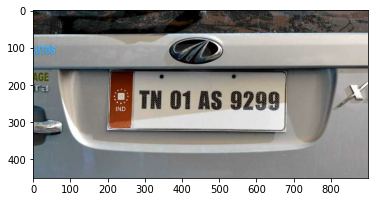

In [ ]:
test_image =cv2.imread('/content/83.jpg')
plt.imshow(test_image)

### batch 4

91
(767, 1024)
side:  341
boundary:  341
92
(900, 1200)
side:  341
boundary:  341
93
94
(2448, 3264)
side:  341
boundary:  341
95
(720, 1280)
side:  455
boundary:  455
96
(200, 251)
side:  321
boundary:  321
97
(616, 903)
side:  375
boundary:  375
98
(338, 600)
side:  454
boundary:  454
99
(228, 221)
side:  264
boundary:  264
100
(174, 290)
side:  426
boundary:  426
101
(194, 260)
side:  343
boundary:  343
102
(675, 1200)
side:  455
boundary:  455
103
(168, 299)
side:  455
boundary:  455
104
(214, 235)
side:  281
boundary:  281
105
(1200, 908)
side:  338
boundary:  338
106
(768, 1112)
side:  370
boundary:  370
107
108
(853, 1136)
side:  340
boundary:  340
109
(159, 318)
side:  512
boundary:  512
110
111
(194, 260)
side:  343
boundary:  343
112
113
(864, 1152)
side:  341
boundary:  341
114
(183, 275)
side:  384
boundary:  384
115
(174, 290)
side:  426
boundary:  426
116
(168, 300)
side:  457
boundary:  457
117
118
119
(628, 1200)
side:  489
boundary:  489
120


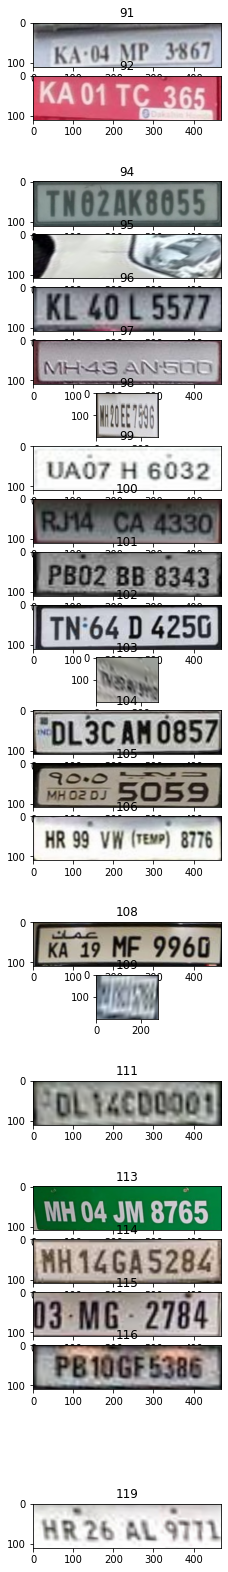

In [ ]:
# batch 1
x=91
y=121
fig = plt.figure(figsize=(30,30))
fig_list = []

for i in range(x,y):
    img = '/content/{}.jpg'.format(i)
    #print(i,sep=' ',end='')
    print(i)
    if i in [93,107,110,112,117,118,120]:
      continue
    fig_list.append(fig.add_subplot(y-90,x-90,i-90))
    fig_list[-1].set_title(i)
    p,c=get_plate(img)
    plt.imshow(p[0])

Found 30 images...
/content/24.jpg
(287, 459)
side:  409
boundary:  409
/content/13.jpg
(2000, 1210)
side:  423
boundary:  423
/content/17.jpg
(1119, 1569)
side:  358
boundary:  358


AssertionError: ignored

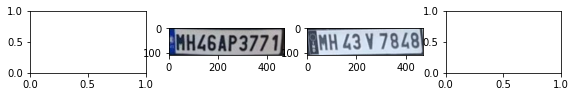

In [ ]:
image_paths = glob.glob("/content/*.jpg")
print("Found %i images..."%(len(image_paths)))
# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 6
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))    
    img=image_paths[i]
    if img=='/content/16.jpg' or img=='/content/21.jpg'or img=='/content/28.jpg'or img=='/content/26.jpg'or img=='/content/30.jpg':
       continue
    print(img)
    LpImg,cor = get_plate(img)
    plt.imshow(LpImg[0])


plt.show()

In [ ]:
pwd

'/content'

In [ ]:
cd Plate_detect_and_recognize/

/content/Plate_detect_and_recognize


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

In [ ]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [ ]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


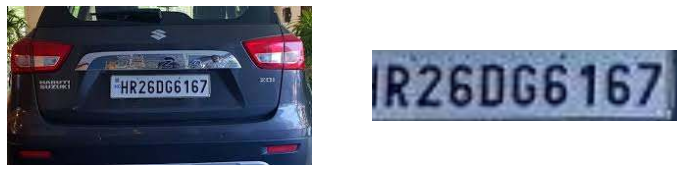

In [ ]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

test_image_path = "/content/58.jpg"
vehicle, LpImg,cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

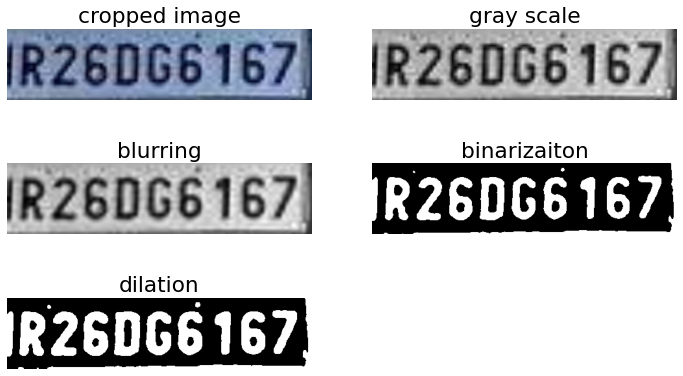

In [ ]:
if (len(LpImg)): #check if there is at least one license image
    
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    binary = cv2.threshold(blur, 180, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["cropped image","gray scale","blurring","binarizaiton","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

# plt.savefig("threshding.png", dpi=300)

Detect 9 letters...


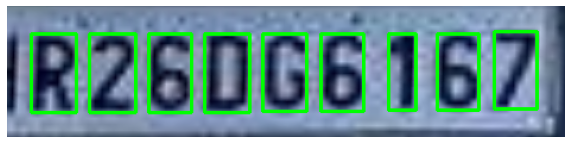

In [ ]:
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)

In [ ]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
#plt.savefig("segmented_leter.png",dpi=300)    

<Figure size 1008x288 with 0 Axes>

In [ ]:
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [ ]:
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

R26DG6167


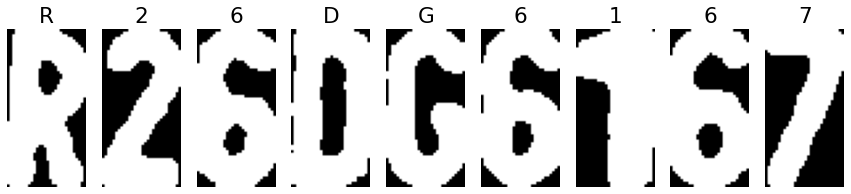

In [ ]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)